In [1]:
import lightgbm as lgb
import optuna.visualization as vis

import numpy as np
import optuna
import sys
import joblib
import pandas as pd
import json
import matplotlib.pyplot as plt
import matplotlib

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

In [2]:
import seaborn as sns

In [3]:
print("Seaborn version:", sns.__version__)
print("Matplotlib version:", matplotlib.__version__)

Seaborn version: 0.13.2
Matplotlib version: 3.10.3


In [4]:
filepath = '../../split_income_data'

### Loading Datasets

In [5]:
test_data_x = pd.read_csv(filepath + '/test/X_test.csv')
test_data_x = test_data_x.drop(columns=['Unnamed: 0'], axis=1)
test_data_y = pd.read_csv(filepath + '/test/y_test.csv')
test_data_y = test_data_y.drop(columns=['Unnamed: 0'], axis=1)

In [6]:
validation = {}
for fold in range(0, 5):
    vdata_x = pd.read_csv(filepath + '/val/X_val_' + str(fold) + '.csv')
    vdata_x = vdata_x.drop(columns=['Unnamed: 0'], axis=1)
    vdata_y = pd.read_csv(filepath + '/val/y_val_' + str(fold) + '.csv')
    vdata_y = vdata_y.drop(columns=['Unnamed: 0'], axis=1)
    validation[fold] = [vdata_x, vdata_y]

In [7]:
train = {}
for fold in range(0, 5):
    tdata_x85 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_85.csv')
    tdata_x85 = tdata_x85.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y85 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_85.csv')
    tdata_y85 = tdata_y85.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x95 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_95.csv')
    tdata_x95 = tdata_x95.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y95 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_95.csv')
    tdata_y95 = tdata_y95.drop(columns=['Unnamed: 0'], axis=1)

    tdata_x1 = pd.read_csv(filepath + '/train/X_train_' + str(fold) + '_1.csv')
    tdata_x1 = tdata_x1.drop(columns=['Unnamed: 0'], axis=1)
    tdata_y1 = pd.read_csv(filepath + '/train/y_train_' + str(fold) + '_1.csv')
    tdata_y1 = tdata_y1.drop(columns=['Unnamed: 0'], axis=1)

    train[fold] = [tdata_x85, tdata_y85, tdata_x95, tdata_y95, tdata_x1, tdata_y1]

### Objective Function

In [8]:
def objective(trial, x_train, y_train, x_val, y_val):

    n_trees = trial.suggest_int("number_trees", 10, 300)

    max_depth = trial.suggest_int("max_tree_depth", 3, 25)

    boosting_type = trial.suggest_categorical("boosting_type", ['gbdt', 'dart'])
    
    bagging_fraction = trial.suggest_float("bagging_fraction", 0.1, 1.0)
    bagging_freq = trial.suggest_int("bagging_freq", 0, 10)

    learning_rate = trial.suggest_float("learning_rate", 0, 1)
    l1_norm = trial.suggest_float("l1_norm", 0, 0.001)
    l2_norm = trial.suggest_float("l2_norm", 0, 0.001)

    lgbm_model = lgb.LGBMRegressor(random_state=42, verbosity = -1, n_estimators=n_trees, boosting=boosting_type, max_depth=max_depth, learning_rate=learning_rate, reg_alpha=l1_norm, reg_lambda=l2_norm, bagging_fraction=bagging_fraction, bagging_freq=bagging_freq)
    trained_model = lgbm_model.fit(x_train, y_train)
    y_pred = trained_model.predict(x_val)
    val_loss = mean_squared_error(y_pred, y_val)

    return val_loss  # Optuna minimizes this

### Model Iteration

#### Code Design

In [16]:
train[0][2 * 2 + 1].column = 'Maternal mortality ratio (national estimate per 100000 live births)'
validation[0][1].column = 'Maternal mortality ratio (national estimate per 100000 live births)'
test_data_y.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

test_data_x['setting'] = test_data_x['setting'].astype("category")
test_data_x.columns = test_data_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)


val_input_data = validation[0][0]
val_input_data['setting'] = val_input_data['setting'].astype("category")
val_input_data.columns = val_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

train_input_data = train[0][2 * 2]
train_input_data['setting'] = train_input_data['setting'].astype("category")
train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

#Create a study object and optimize the objective function.
study = optuna.create_study(direction='minimize')
study.optimize(lambda trial: objective(trial, train_input_data, train[0][2 * 2 + 1], val_input_data, validation[0][1]), n_trials=2)
best_model = lgb.LGBMRegressor(**study.best_params)
best_model.fit(train_input_data, train[0][2 * 2 + 1])

best_pred = best_model.predict(val_input_data)
best_val_loss = mean_squared_error(best_pred, validation[0][1])

best_pred_test = best_model.predict(test_data_x)
best_test_loss = mean_squared_error(best_pred_test, test_data_y)

[I 2025-07-20 18:18:50,308] A new study created in memory with name: no-name-832d9ad4-abe2-4f9f-8c00-c79fb7e8903f
[I 2025-07-20 18:18:50,508] Trial 0 finished with value: 11140.56109899367 and parameters: {'number_trees': 12, 'max_tree_depth': 25, 'boosting_type': 'gbdt', 'bagging_fraction': 0.8037037017991651, 'bagging_freq': 3, 'learning_rate': 0.44083514797807155, 'l1_norm': 0.00025116528749827727, 'l2_norm': 0.0008364932166986137}. Best is trial 0 with value: 11140.56109899367.
[I 2025-07-20 18:18:51,193] Trial 1 finished with value: 14130.03860744354 and parameters: {'number_trees': 118, 'max_tree_depth': 13, 'boosting_type': 'gbdt', 'bagging_fraction': 0.3744213102675306, 'bagging_freq': 6, 'learning_rate': 0.4235580516633216, 'l1_norm': 0.0007751307143550002, 'l2_norm': 0.0009494217487030815}. Best is trial 0 with value: 11140.56109899367.


In [15]:
import re 
special_cols = [col for col in train_input_data.columns if re.search(r'[\"\[\]\{\}\\:,]', col)]
print("Columns with problematic characters:", special_cols)

Columns with problematic characters: ['Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 5-14 (% of population ages 5-14)', 'Mortality rate attributed to household and ambient air pollution, age-standardized, female (per 100,000 female population)', 'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 0-4 (% of population ages 0-4)', 'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 60+ (% of population ages 60+)', 'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 60+, male (% of male population ages 60+)', 'Comprehensive correct knowledge of HIV/AIDS, ages 15-24, male (2 prevent ways and reject 3 misconceptions)', 'Mortality rate attributed to unsafe water, unsafe sanitation and lack of hygiene (per 100,000 population)', 'Mortality rate, infant (per 1,000 live births)', 'Cause of death, by communicable disea

#### Code Implementation

In [9]:
output_dir = '../../split_income_models/lightgbm'

In [10]:
#because lightgbm cannot handle the comma
test_data_y.column = 'Maternal mortality ratio (national estimate per 100000 live births)'
test_data_x['setting'] = test_data_x['setting'].astype("category")
test_data_x.columns = test_data_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

for fold in range(0, 5):
    val_input_data = validation[fold][0].copy()
    val_input_data['setting'] = val_input_data['setting'].astype("category")
    val_input_data.columns = val_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
    val_label = validation[fold][1].copy()
    val_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

    for thresh_idx, thresh in enumerate(['85', '95', '1']):
        if thresh_idx != 2:
            continue
        train_input_data = train[fold][thresh_idx * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        train_label = train[fold][thresh_idx * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        #Create a study object and optimize the objective function.
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, train_input_data, train_label, val_input_data, val_label), n_trials=300)
        best_model = lgb.LGBMRegressor(**study.best_params)
        best_model.fit(train_input_data, train_label)
        
        #save best model 
        joblib.dump(best_model, output_dir + '/best_model_' + str(fold) + '_' + thresh +  '.pkl')
        joblib.dump(study.best_params, f"{output_dir}/best_params_{fold}_{thresh}.pkl")

        # Save study for later visualization
        joblib.dump(study, f"{output_dir}/optuna_study_{fold}_{thresh}.pkl")

        summary = {
            "dataset": str(fold) + '_' + thresh,
            "fold" : fold,
            "threshold": thresh,
            "model": 'lightgbm',
            "best_params": study.best_params,
            "best_optuna_loss": study.best_value
        }

        with open(f"{output_dir}/results_{fold}_{thresh}.json", "w") as f:
            json.dump(summary, f, indent=2)

[I 2025-07-25 13:48:15,503] A new study created in memory with name: no-name-1514f1b9-77d2-4ca8-8054-53d1f0725df3
[I 2025-07-25 13:48:17,343] Trial 0 finished with value: 9996.622697413119 and parameters: {'number_trees': 69, 'max_tree_depth': 19, 'boosting_type': 'gbdt', 'bagging_fraction': 0.993109832484711, 'bagging_freq': 0, 'learning_rate': 0.5969415612041371, 'l1_norm': 0.00028488197144214766, 'l2_norm': 0.0005120318406305084}. Best is trial 0 with value: 9996.622697413119.
[I 2025-07-25 13:48:19,328] Trial 1 finished with value: 14130.641430700072 and parameters: {'number_trees': 267, 'max_tree_depth': 3, 'boosting_type': 'gbdt', 'bagging_fraction': 0.9646701053376665, 'bagging_freq': 9, 'learning_rate': 0.9982353631957376, 'l1_norm': 0.0002947067402221433, 'l2_norm': 0.0008393221685389751}. Best is trial 0 with value: 9996.622697413119.
[I 2025-07-25 13:48:19,581] Trial 2 finished with value: 8533.996372867212 and parameters: {'number_trees': 41, 'max_tree_depth': 4, 'boosting_

Now looking at instances where data has been dropped due to the missing data thresholds

#### Experimenting with column subsets

In [165]:
val_input_data = validation[0][0].copy()
train_input_data = train[0][0].copy()
columns_needed = val_input_data.columns.intersection(train_input_data.columns)
columns_needed

Index(['date', 'setting',
       'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 5-14 (% of population ages 5-14)',
       'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 0-4 (% of population ages 0-4)',
       'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 60+ (% of population ages 60+)',
       'Antiretroviral therapy coverage (% of adult males living with HIV)',
       'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 60+, male (% of male population ages 60+)',
       'Mortality rate, infant (per 1,000 live births)',
       'Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 15-59 (% of population ages 15-59)',
       'Cause of death, by injury, ages 15-59, female (% of female population ages 15-59)',
       ...
       'Unemployment with intermediate e

In [166]:
diff_columns = train_input_data.columns.difference(val_input_data.columns)
print(diff_columns)

Index([], dtype='object')


In [168]:
val_input_data[columns_needed]

,date,setting,"Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 5-14 (% of population ages 5-14)","Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 0-4 (% of population ages 0-4)","Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 60+ (% of population ages 60+)",Antiretroviral therapy coverage (% of adult males living with HIV),"Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 60+, male (% of male population ages 60+)","Mortality rate, infant (per 1,000 live births)","Cause of death, by communicable diseases and maternal, prenatal and nutrition conditions, ages 15-59 (% of population ages 15-59)","Cause of death, by injury, ages 15-59, female (% of female population ages 15-59)",...,Unemployment with intermediate education (% of total labor force with intermediate education) male,"Share of youth not in education, employment or training (% of youth population) female","Share of youth not in education, employment or training (% of youth population) male",Trained teachers in secondary education (% of total teachers) female,Trained teachers in secondary education (% of total teachers) male,Trained teachers in preprimary education (% of total teachers) female,Trained teachers in preprimary education (% of total teachers) male,Trained teachers in primary education (% of total teachers) female,Trained teachers in primary education (% of total teachers) male,income_num
0,2004.0,Armenia,NaN,NaN,NaN,0.0,NaN,22.3,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,66.499702,84.482758,3.0
1,2007.0,Singapore,NaN,NaN,NaN,NaN,NaN,2.3,NaN,NaN,...,3.640,NaN,NaN,99.268631,99.910049,NaN,NaN,99.436012,98.012512,4.0
2,2014.0,Suriname,NaN,NaN,NaN,29.0,NaN,18.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
3,2007.0,Armenia,NaN,NaN,NaN,7.0,NaN,19.2,NaN,NaN,...,22.070,44.868,31.125,NaN,NaN,NaN,NaN,NaN,NaN,3.0
4,1987.0,Kazakhstan,NaN,NaN,NaN,NaN,NaN,47.0,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
486,1985.0,Kazakhstan,NaN,NaN,NaN,NaN,NaN,49.9,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
487,2006.0,Kazakhstan,NaN,NaN,NaN,NaN,NaN,25.6,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0
488,2016.0,Colombia,NaN,NaN,NaN,50.0,NaN,13.0,NaN,NaN,...,7.869,28.779,13.660,98.704247,97.556808,NaN,NaN,95.816727,91.585320,3.0
489,1991.0,Tajikistan,NaN,NaN,NaN,NaN,NaN,82.7,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.0


### Column Subsets

In [11]:
#because lightgbm cannot handle the comma
test_data_y.column = 'Maternal mortality ratio (national estimate per 100000 live births)'
test_data_x['setting'] = test_data_x['setting'].astype("category")
test_data_x.columns = test_data_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

for fold in range(0, 5):
    val_input_data = validation[fold][0].copy()
    val_input_data['setting'] = val_input_data['setting'].astype("category")
    val_input_data.columns = val_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
    val_label = validation[fold][1].copy()
    val_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

    for thresh_idx, thresh in enumerate(['85', '95', '1']):
        if thresh_idx == 2:
            continue

        train_input_data = train[fold][thresh_idx * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)
        train_label = train[fold][thresh_idx * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        columns_needed = val_input_data.columns.intersection(train_input_data.columns)
        val_relevant_input = val_input_data[columns_needed]

        #Create a study object and optimize the objective function.
        study = optuna.create_study(direction='minimize')
        study.optimize(lambda trial: objective(trial, train_input_data, train_label, val_relevant_input, val_label), n_trials=300)
        best_model = lgb.LGBMRegressor(**study.best_params)
        best_model.fit(train_input_data, train_label)
        
        #save best model 
        joblib.dump(best_model, output_dir + '/best_model_' + str(fold) + '_' + thresh +  '.pkl')
        joblib.dump(study.best_params, f"{output_dir}/best_params_{fold}_{thresh}.pkl")

        # Save study for later visualization
        joblib.dump(study, f"{output_dir}/optuna_study_{fold}_{thresh}.pkl")

        summary = {
            "dataset": str(fold) + '_' + thresh,
            "fold" : fold,
            "threshold": thresh,
            "model": 'lightgbm',
            "best_params": study.best_params,
            "best_optuna_loss": study.best_value
        }

        with open(f"{output_dir}/results_{fold}_{thresh}.json", "w") as f:
            json.dump(summary, f, indent=2)

[I 2025-07-25 14:28:50,918] A new study created in memory with name: no-name-92d05b69-50fd-4593-81ad-32598a9e37e4
[I 2025-07-25 14:28:51,500] Trial 0 finished with value: 11732.72242247366 and parameters: {'number_trees': 152, 'max_tree_depth': 23, 'boosting_type': 'dart', 'bagging_fraction': 0.22367446253838366, 'bagging_freq': 10, 'learning_rate': 0.6008614867662208, 'l1_norm': 0.0006930951726356942, 'l2_norm': 0.0009851570078147982}. Best is trial 0 with value: 11732.72242247366.
[I 2025-07-25 14:28:51,746] Trial 1 finished with value: 18160.809979865015 and parameters: {'number_trees': 56, 'max_tree_depth': 23, 'boosting_type': 'gbdt', 'bagging_fraction': 0.2504847378643021, 'bagging_freq': 7, 'learning_rate': 0.5647214907107159, 'l1_norm': 0.0007761993873058963, 'l2_norm': 0.0009791300879624582}. Best is trial 0 with value: 11732.72242247366.
[I 2025-07-25 14:28:55,425] Trial 2 finished with value: 12725.876492909181 and parameters: {'number_trees': 268, 'max_tree_depth': 22, 'boo

### Loading Models

In [24]:
output_dir = '../../split_income_models/lightgbm'

#### Test values for all models

In [25]:
# setting up the dataframe to hold test results
index = pd.MultiIndex.from_tuples(
    [('Threshold 85%', '1'), ('Threshold 85%', '2'), ('Threshold 85%', '3'), ('Threshold 85%', '4'), ('Threshold 85%', '5'),
     ('Threshold 95%', '1'), ('Threshold 95%', '2'), ('Threshold 95%', '3'), ('Threshold 95%', '4'), ('Threshold 95%', '5'),
     ('None', '1'), ('None', '2'), ('None', '3'), ('None', '4'), ('None', '5')],
    names=['Missing Data Threshold', 'Fold']
)
test_stats = pd.DataFrame(index=index, columns=['MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])

test_stats

MAPE  MAE  MSE RMSE   R2
Missing Data Threshold Fold                         
Threshold 85%          1     NaN  NaN  NaN  NaN  NaN
                       2     NaN  NaN  NaN  NaN  NaN
                       3     NaN  NaN  NaN  NaN  NaN
                       4     NaN  NaN  NaN  NaN  NaN
                       5     NaN  NaN  NaN  NaN  NaN
Threshold 95%          1     NaN  NaN  NaN  NaN  NaN
                       2     NaN  NaN  NaN  NaN  NaN
                       3     NaN  NaN  NaN  NaN  NaN
                       4     NaN  NaN  NaN  NaN  NaN
                       5     NaN  NaN  NaN  NaN  NaN
None                   1     NaN  NaN  NaN  NaN  NaN
                       2     NaN  NaN  NaN  NaN  NaN
                       3     NaN  NaN  NaN  NaN  NaN
                       4     NaN  NaN  NaN  NaN  NaN
                       5     NaN  NaN  NaN  NaN  NaN

In [26]:
test_data_y.iloc[0] + 5

Maternal mortality ratio (national estimate, per 100,000 live births)    72.0
Name: 0, dtype: float64

In [27]:
best_parameters = {'Threshold 85%' : [], 'Threshold 95%' : [], 'None' : []}

In [28]:
test_data_x['setting'] = test_data_x['setting'].astype("category")
testing_x = test_data_x.copy()
testing_x.columns = testing_x.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

for fold, fold_num in enumerate(['1', '2', '3', '4', '5']):
    for thresh, thresh_name in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
        
        if thresh == 0:
            name = '85'
        elif thresh == 1:
            name = '95'
        else: name = '1'

        best_params = joblib.load(f"{output_dir}/best_params_{fold}_{name}.pkl")
        best_parameters[thresh_name].append(best_params)
        best_model = joblib.load(f"{output_dir}/best_params_{fold}_{name}.pkl")

        train_input_data = train[fold][thresh * 2].copy()
        train_input_data['setting'] = train_input_data['setting'].astype("category")
        train_input_data.columns = train_input_data.columns.str.replace(r'[\"\[\]\{\}\\:,]', '', regex=True)

        train_label = train[fold][thresh * 2 + 1].copy()
        train_label.column = 'Maternal mortality ratio (national estimate per 100000 live births)'

        columns_needed = testing_x.columns.intersection(train_input_data.columns)
        to_test = testing_x[columns_needed].copy()

        loaded_model = lgb.LGBMRegressor(**best_params, verbosity = -1)
        train_load = loaded_model.fit(train_input_data, train_label)
        prediction = train_load.predict(to_test)
        mse = mean_squared_error(prediction, test_data_y)
        mae = mean_absolute_error(prediction, test_data_y)
        rmse = np.sqrt(mse)
        r2 = r2_score(prediction, test_data_y)

        #to calculate mape
        num_predictions = len(prediction)
        mape = 0
        for p in range(0, num_predictions):
            mape += np.abs(prediction[p] - test_data_y.iloc[p]) / np.maximum(np.abs(prediction[p]), np.abs(test_data_y.iloc[p]))
        mape = mape/num_predictions
        #mape = (1/num_predictions) * np.sum(np.abs(prediction - test_data_y) / np.max(np.abs(prediction), np.abs(test_data_y)))

        test_stats.loc[(thresh_name, fold_num), 'MSE'] = mse
        test_stats.loc[(thresh_name, fold_num), 'MAE'] = mae
        test_stats.loc[(thresh_name, fold_num), 'RMSE'] = rmse
        test_stats.loc[(thresh_name, fold_num), 'R2'] = r2
        test_stats.loc[(thresh_name, fold_num), 'MAPE'] = mape[0]
        

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_10420/836377741.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_10420/836377741.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  test_stats.loc[(thresh_name, fold_num), 'MAPE'] = mape[0]
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_10420/836377741.py:48: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame 

In [29]:
test_stats

MAPE        MAE           MSE        RMSE  \
Missing Data Threshold Fold                                                  
Threshold 85%          1     0.529106  40.130823   8437.314157   91.854854   
                       2     0.469028  41.047769   7758.927669   88.084775   
                       3     0.522542  45.277291   9636.662713   98.166505   
                       4     0.570553  48.520626  13807.045956  117.503387   
                       5     0.616627  61.992587  12902.115628   113.58748   
Threshold 95%          1     0.467093  37.138755   7614.790216   87.262765   
                       2      0.42683  36.958467   8050.703376   89.725712   
                       3     0.441013  37.949931   8185.922592   90.476089   
                       4     0.555512  44.025743   9593.588731   97.946867   
                       5     0.483978   36.65634   8111.803174   90.065549   
None                   1     0.456556  36.574602   8160.919448   90.337807   
                       2     0.422713  34.946572   8192.209935   90.510828   
                       3     0.496534  43.492708  11300.213446  106.302462   
                       4     0.573279  41.800804   9238.379835   96.116491   
                       5     0.474209  39.627456   8777.915427    93.69053   

                                   R2  
Missing Data Threshold Fold            
Threshold 85%          1     0.536467  
                       2     0.683664  
                       3      0.67915  
                       4     0.560669  
                       5     0.556055  
Threshold 95%          1     0.657066  
                       2     0.530308  
                       3     0.605975  
                       4      0.42423  
                       5     0.636934  
None                   1     0.644082  
                       2     0.538591  
                       3     0.447303  
                       4     0.504961  
                       5     0.618947

In [30]:
mean_summary = test_stats.groupby(level='Missing Data Threshold').mean()
mean_summary = mean_summary.astype('float')
mean_summary = mean_summary.round(2)
std_summary = test_stats.groupby(level='Missing Data Threshold').std()
std_summary = std_summary.astype('float')
std_summary = std_summary.round(2)

In [31]:
# setting up the dataframe to hold summary of cross-fold validation results
summary_index = pd.MultiIndex.from_tuples(
    [('Threshold 85%', '1'), ('Threshold 85%', '2'), ('Threshold 85%', '3'), ('Threshold 85%', '4'), ('Threshold 85%', '5'),
     ('Threshold 95%', '1'), ('Threshold 95%', '2'), ('Threshold 95%', '3'), ('Threshold 95%', '4'), ('Threshold 95%', '5'),
     ('None', '1'), ('None', '2'), ('None', '3'), ('None', '4'), ('None', '5')],
    names=['Missing Data Threshold', 'Fold']
)

summary_stats = pd.DataFrame(index=['Threshold 85%', 'Threshold 95%', 'None'], columns=['MAPE', 'MAE', 'MSE', 'RMSE', 'R2'])

for thresh_idx, thresh in enumerate(['Threshold 85%', 'Threshold 95%', 'None']):
    for metric_idx, metric in enumerate(['MAPE', 'MAE', 'MSE', 'RMSE', 'R2']):
        summary_stats.iloc[thresh_idx][metric_idx] = str(mean_summary.iloc[thresh_idx][metric_idx]) + ' +- ' + str(std_summary.iloc[thresh_idx][metric_idx])

summary_stats

/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_10420/2971279602.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  summary_stats.iloc[thresh_idx][metric_idx] = str(mean_summary.iloc[thresh_idx][metric_idx]) + ' +- ' + str(std_summary.iloc[thresh_idx][metric_idx])
/var/folders/jd/0gmk2m5x1cl2hh0v_hsx43q40000gn/T/ipykernel_10420/2971279602.py:13: FutureWarning: Series.__setitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To set a value by position, use `ser.iloc[pos] = value`
  summary_stats.iloc[thresh_idx][metric_idx] = str(mean_summary.iloc[thresh_idx][metric_idx]) + ' +- ' + str(std_summary.iloc[thresh_idx][metric_idx])


,MAPE,MAE,MSE,RMSE,R2
Threshold 85%,0.48 +- 0.06,39.29 +- 3.55,9133.93 +- 1290.74,95.39 +- 6.55,0.55 +- 0.08
Threshold 95%,0.54 +- 0.06,47.39 +- 8.83,10508.41 +- 2702.77,101.84 +- 13.09,0.6 +- 0.07
None,0.47 +- 0.05,38.55 +- 3.1,8311.36 +- 750.47,91.1 +- 4.03,0.57 +- 0.1


#### Best Parameters

#### Visualisation

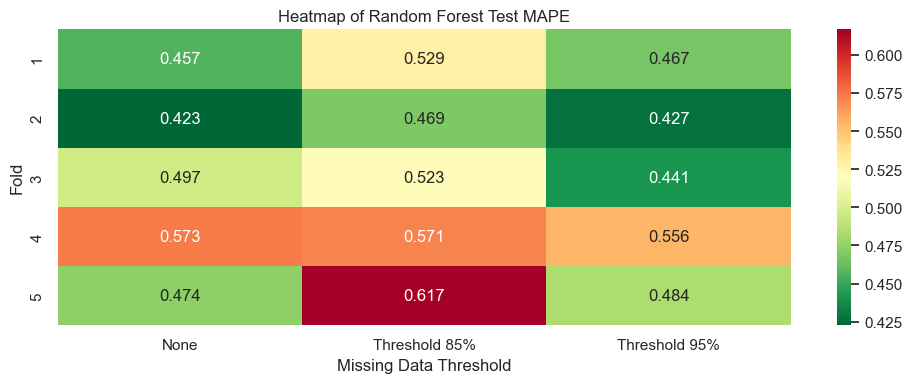

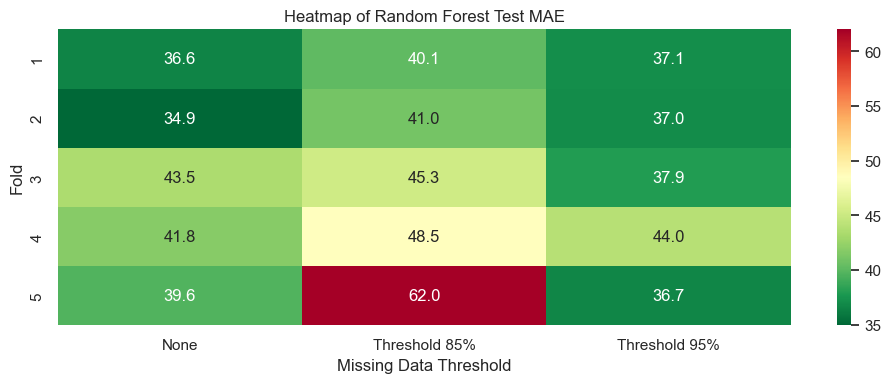

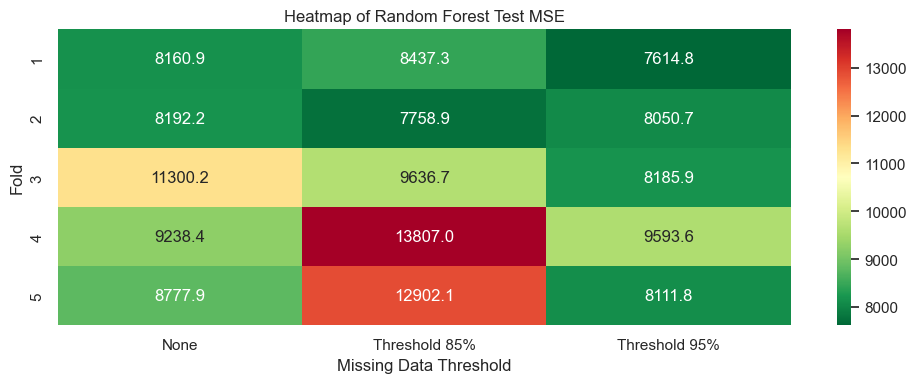

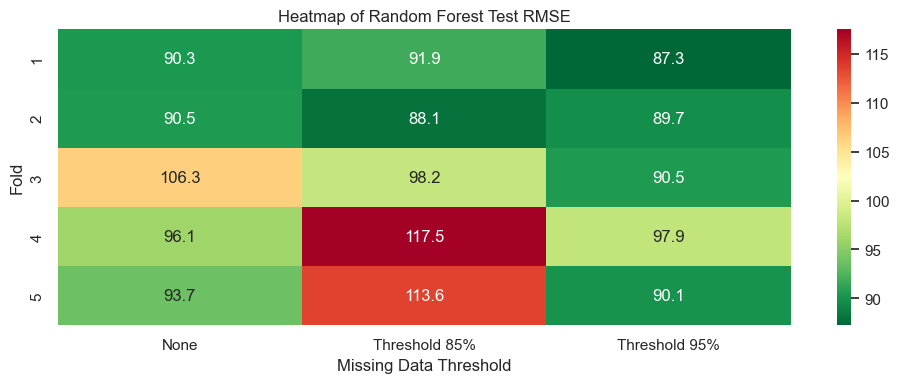

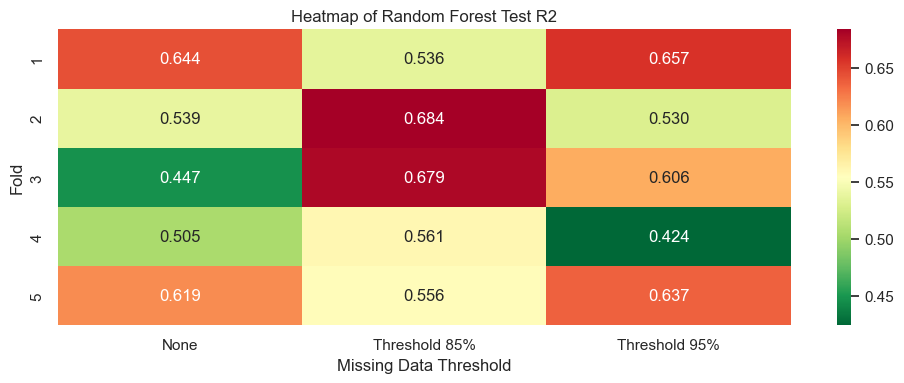

In [32]:
import seaborn as sns

data = test_stats.astype(float)

for metric in data.columns:
    plt.figure(figsize=(10, 4))
    d = pd.DataFrame(data[metric].unstack(level='Missing Data Threshold'))
    if metric == 'MAPE' or metric == 'R2':
        fmt = ".3f"
    else:
        fmt = ".1f"
    sns.heatmap(d, annot=True, fmt=fmt, cmap="RdYlGn_r", cbar=True)
    sns.set_theme(context='notebook', style='whitegrid')  # or 'paper'
    plt.title("Heatmap of Random Forest Test " + metric)
    plt.xlabel("Missing Data Threshold")
    plt.ylabel("Fold")
    plt.tight_layout()
    plt.show()

In [33]:
d.values

array([[0.64408232, 0.53646727, 0.65706604],
       [0.538591  , 0.68366379, 0.53030826],
       [0.44730265, 0.67915043, 0.60597509],
       [0.50496067, 0.56066865, 0.42422984],
       [0.61894691, 0.55605526, 0.63693401]])

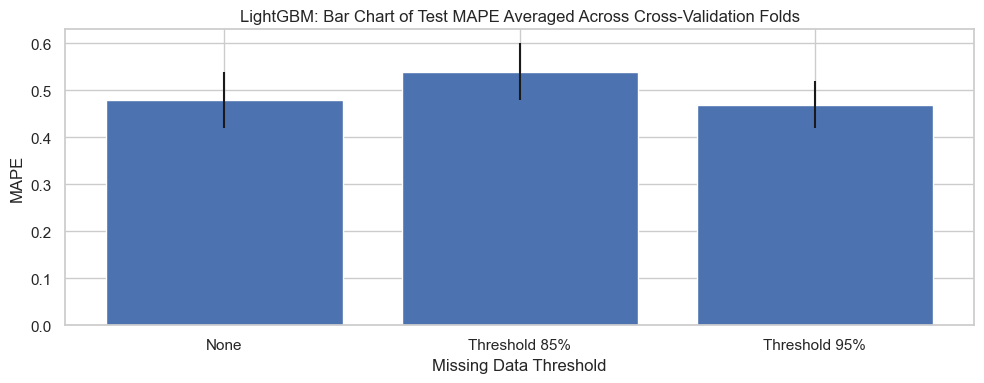

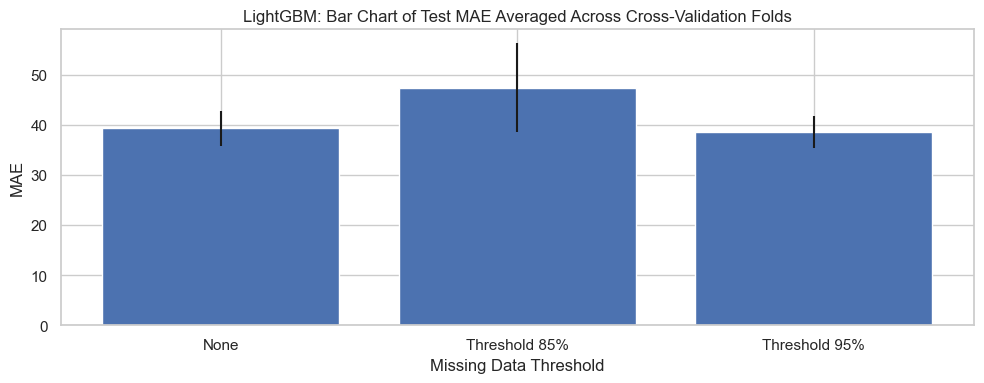

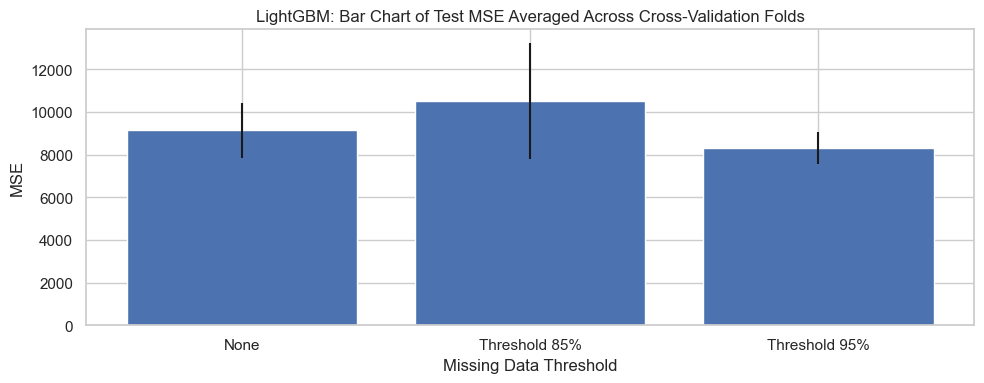

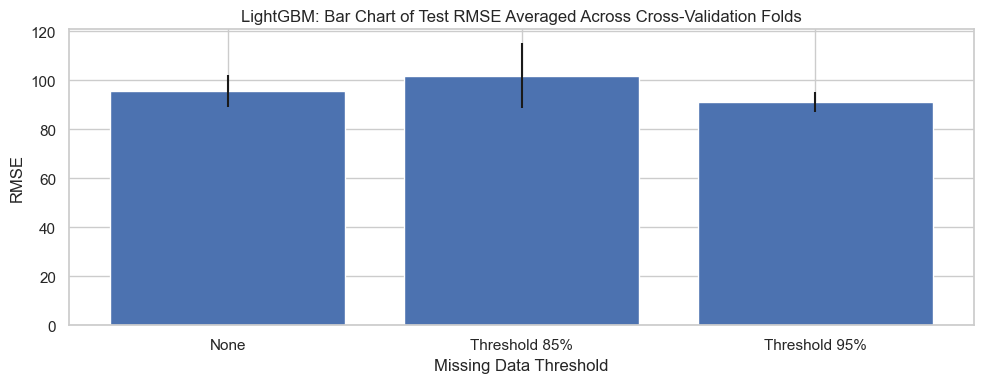

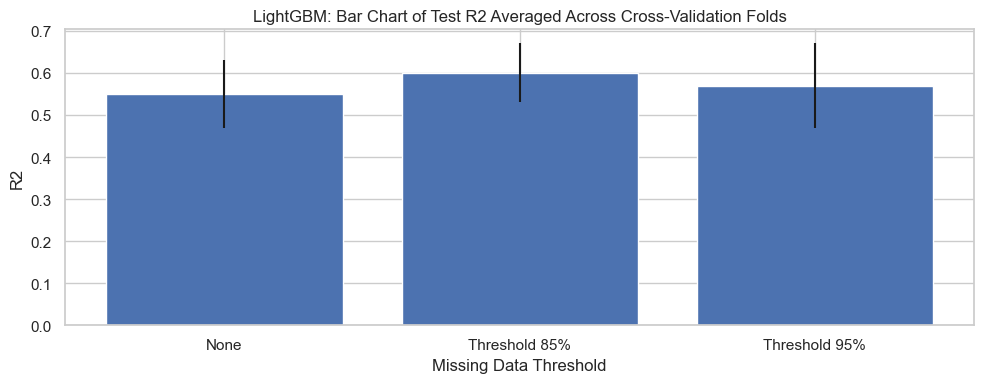

In [34]:
mean_data = mean_summary.astype(float)
std_data = std_summary.astype(float)

for metric in mean_data.columns:
    plt.figure(figsize=(10, 4))
    d_full = mean_data[metric]
    d = mean_data[metric].values
    e = std_data[metric].values
    plt.bar(d_full.index, d, yerr = e)
    plt.title("LightGBM: Bar Chart of Test " + metric + " Averaged Across Cross-Validation Folds")
    plt.xlabel("Missing Data Threshold")
    plt.ylabel(metric)
    plt.tight_layout()
    plt.show()

In [35]:
mean_corr = mean_summary.corr()
mean_corr

,MAPE,MAE,MSE,RMSE,R2
MAPE,1.000000,0.998380,0.969622,0.962277,0.857146
MAE,0.998380,1.000000,0.954131,0.945235,0.885068
MSE,0.969622,0.954131,1.000000,0.999596,0.705117
RMSE,0.962277,0.945235,0.999596,1.000000,0.684675
R2,0.857146,0.885068,0.705117,0.684675,1.000000


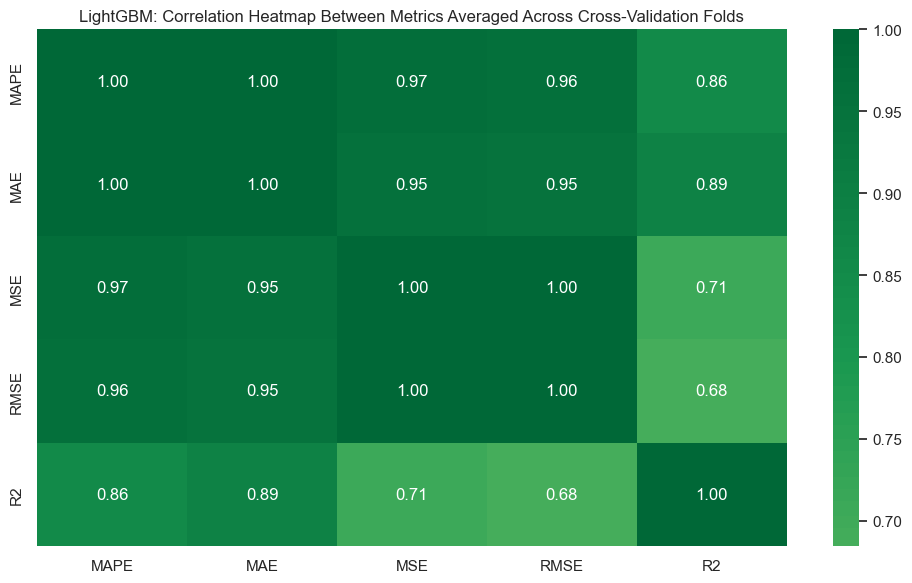

In [36]:
plt.figure(figsize=(10, 6))
sns.heatmap(mean_corr, annot=True, fmt=".2f", cmap="RdYlGn", center=0)
plt.title("LightGBM: Correlation Heatmap Between Metrics Averaged Across Cross-Validation Folds")
plt.tight_layout()
plt.show()

### extras